<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

In [1]:
%run supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



# Control DCGAN

In [2]:
import torch
import gc
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

from svlearn.config.configuration import ConfigurationMixin
from svlearn_gan.dcgan_models import TreeGenerator
from svlearn_gan.classifier import get_tree_classifier
from svlearn_gan.control_gan import control_generation


In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
config = ConfigurationMixin().load_config()
data_dir = config['tree-classification']['data']
results_dir = config['tree-classification']['results']

Load the trained generator as well as the classifier that will later be used to move the noise along the gradient of the logits wrt noise

In [5]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Global variables
# Number of channels in the training images. For color images this is 3
nc = config['tree-classification']['num_channels']

# Size of z latent vector (i.e. size of generator input)
nz = config['tree-classification']['nz']

# Size of feature maps in generator
ngf = config['tree-classification']['ngf']

# Size of feature maps in discriminator
ndf = config['tree-classification']['ndf']

# number of classes of training images
num_classes = config['tree-classification']['num_classes']

In [6]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = torch.device("mps") if torch.backends.mps.is_available() else device
# Create the generator

netG = TreeGenerator(nz, ngf, nc ).to(device)

In [7]:
gen_checkpoint = torch.load(f"{results_dir}/generator.pt")
netG.load_state_dict(gen_checkpoint["model_state_dict"])
netG.eval()

TreeGenerator(
  (first_layer): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (subsequent_layers): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

In [8]:
from svlearn_gan.gan_trainer import load_checkpoint

checkpoint_generator_file = f'{results_dir}/control-classifier.pt'
classifier = get_tree_classifier()
load_checkpoint(classifier , checkpoint_generator_file)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=800, out_features=180, bias=True)
  (14): ReLU()
  (15): Linear(in_features=180, out_features=84, bias=True)
  (16): ReLU()
  (17): Linear(in_features=84, out_features=2, bias=True)
)

In [9]:
classifier.to(device)
classifier.eval()

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=800, out_features=180, bias=True)
  (14): ReLU()
  (15): Linear(in_features=180, out_features=84, bias=True)
  (16): ReLU()
  (17): Linear(in_features=84, out_features=2, bias=True)
)

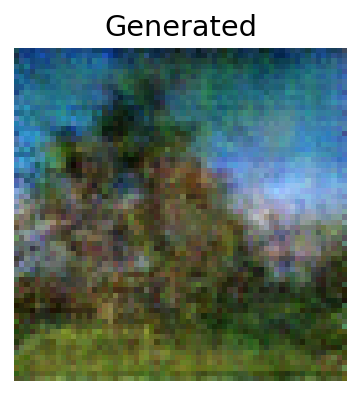

In [10]:
# Create batch of latent vectors that we will use to visualize the generator
noise = torch.randn(1, nz, 1, 1, device=device)

with torch.no_grad():
    fake = netG(noise).cpu()

image_grid = vutils.make_grid(fake, padding=2, normalize=True)
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
axes.axis("off")
axes.set_title("Generated")
axes.imshow(np.transpose(image_grid,(1,2,0)))

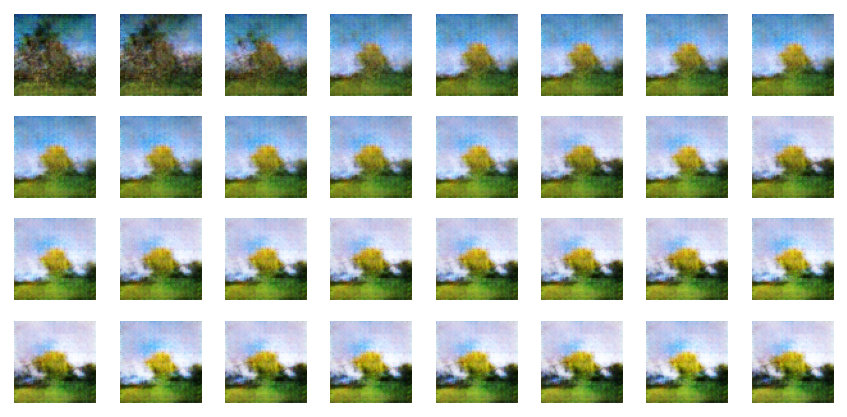

In [11]:
fake_images = control_generation(generator=netG, classifier=classifier, z=noise, target_class=1, steps=32, alpha=0.3)

# Set up the figure and axes for a 4x4 grid
fig, axes = plt.subplots(4, 8, figsize=(6,3))


for i, ax in enumerate(axes.flat):
    image_grid = vutils.make_grid(torch.tensor(fake_images[i]), padding=2, normalize=True)
    ax.imshow(np.transpose(image_grid, (1, 2, 0)), cmap='gray')  # Use your preferred colormap
    ax.axis('off')


plt.tight_layout()  # Adjust layout for better spacing
plt.show()